# Multicompartment model of vascularized solid tumors
- This code supports the paper titled: "Multicompartment modeling of protein shedding kinetics during vascularized tumor growth".
- Python scripts (.py) are loaded for function calling to streamline the experiments run in this notebook - the first 4 imports below are the mentioned python scripts.
- Developed by Gautam Machiraju and advised by Drs. Parag Mallick and Hermann Frieboes.

## Imports and Function loading

In [3]:
from models import *
from analyzer import *
from data_structs import *
from plotter import *

import pandas as pd
import numpy as np
import scipy as sci
import pdb
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Global parameters

In [4]:
maxYears = 12
maxIter = maxYears * 365  # days

# set up meshed parameter space (Note: Phi_0s = O2maxs) ** distinguish how
# this is different for in vivo Phi_0 really means somethign different for
# plated cells.

O2a = 12  # 12 gives almost nothing valid
O2b = 20
O2maxs = list(range(O2a, O2b + 1))

kva = 1 * (10 ** -3)
kvb = 2 * (10 ** -1)
kvs = list(np.linspace(start=kva, stop=kvb, num=20))

sigma = 0.01

# birth and death rate data
y1B, y1D = 0.00078367, 0.00156509
y20B, y20D = 0.0082206, 0
rates = [y1B, y1D, y20B, y20D]

# simulation step size
step=1 # 0.1


In [5]:
print(O2maxs)
print(kvs)

[12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.001, 0.011473684210526316, 0.021947368421052632, 0.03242105263157895, 0.04289473684210526, 0.05336842105263158, 0.0638421052631579, 0.07431578947368421, 0.08478947368421053, 0.09526315789473684, 0.10573684210526316, 0.11621052631578947, 0.1266842105263158, 0.1371578947368421, 0.14763157894736842, 0.15810526315789475, 0.16857894736842105, 0.17905263157894735, 0.18952631578947368, 0.2]


## Helper Functions

In [6]:
def sens_marker_params(n_points, Fe_arr, Fne_arr, P, N, n, maxIter):
    arr = []
    for i in range(n_points):
        sh = ShedObj(Fe_arr[i], P, N, n, maxIter)
        arr.append(ST_shed(sh, dt=step))
    for i in range(n_points):
        sh = ShedObj(Fne_arr[i], P, N, n, maxIter)
        arr.append(ST_shed(sh, dt=step))
    return arr

def sens_tumor_params(n_points, Fe, Fne, grow_objs, maxIter):
    arr = []
    for i in range(n_points):
        sh = ShedObj(Fe, grow_objs[i].NmatA, grow_objs[
            i].NmatD, grow_objs[i].n, maxIter)
        arr.append(ST_shed(sh, dt=step))
    for i in range(n_points):
        sh = ShedObj(Fne, grow_objs[i].NmatA, grow_objs[
            i].NmatD, grow_objs[i].n, maxIter)
        arr.append(ST_shed(sh, dt=step))
    return arr

def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

def serialize(obj, path):
    with open(path, 'wb') as fh:
        pickle.dump(obj, fh)

def deserialize(path):
    with open(path, 'rb') as fh:
        return pickle.load(fh)


## 1. Tumor growth simulations - model mesh/grid search 
This is the simulation grid search over our parameter space. This is performed to get multiple runs and select models that are deemed "valid" given some a priori constraints.

In [7]:
# parameters of run (toggle) -- False overrides the cache
mesh_cached = True

In [8]:
if mesh_cached == False:
    print(
        "\nOverwriting and running full MESH... This may take a few minutes.")
    mesh_obj = MeshObj(maxIter, kvs, O2maxs, sigma, rates)
    mesh_obj = ST_grow_mesh(mesh_obj)

    if mesh_obj is not None:
        serialize(mesh_obj, 'mesh_cached.obj')
        
elif mesh_cached == True:
    print("\nUsing old MESH run & proceeding with MESH analysis!")

mesh_cached = deserialize('mesh_cached.obj')


Using old MESH run & proceeding with MESH analysis!


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


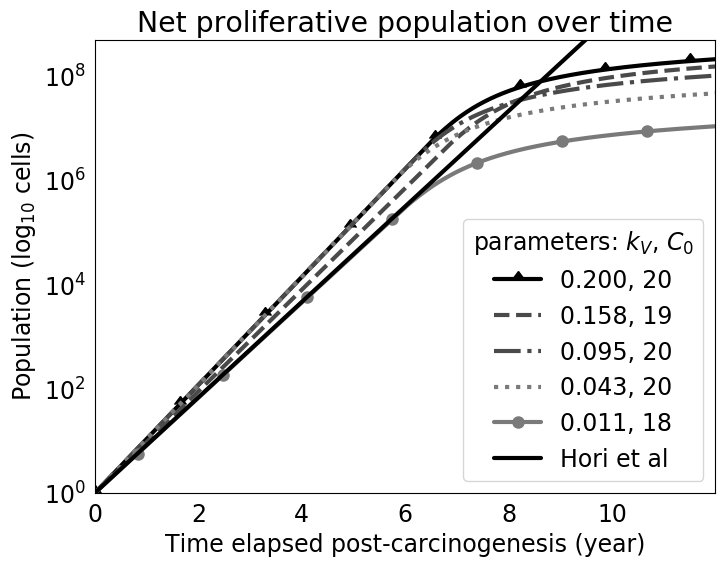

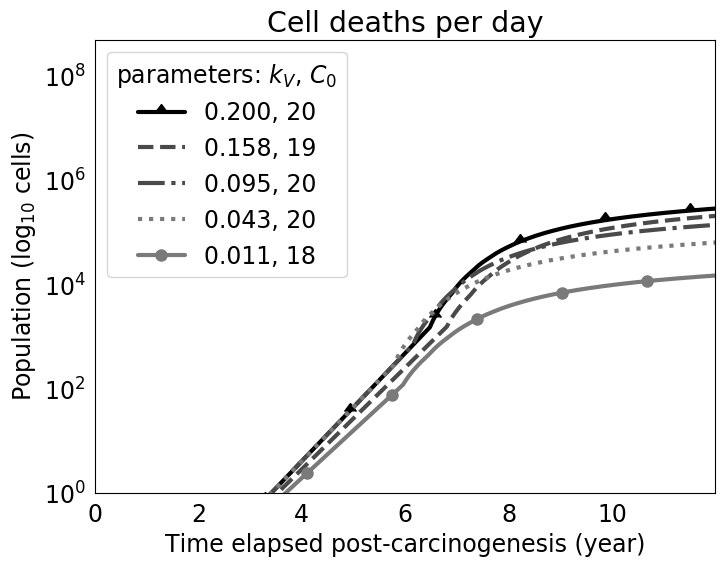

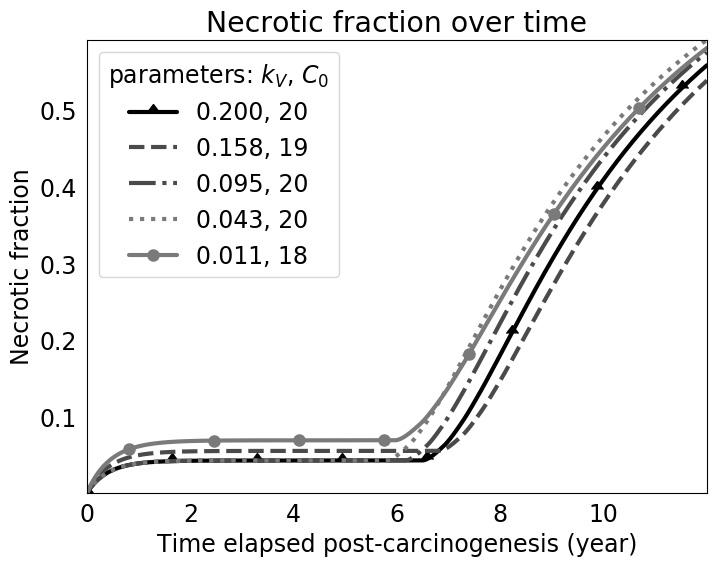

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


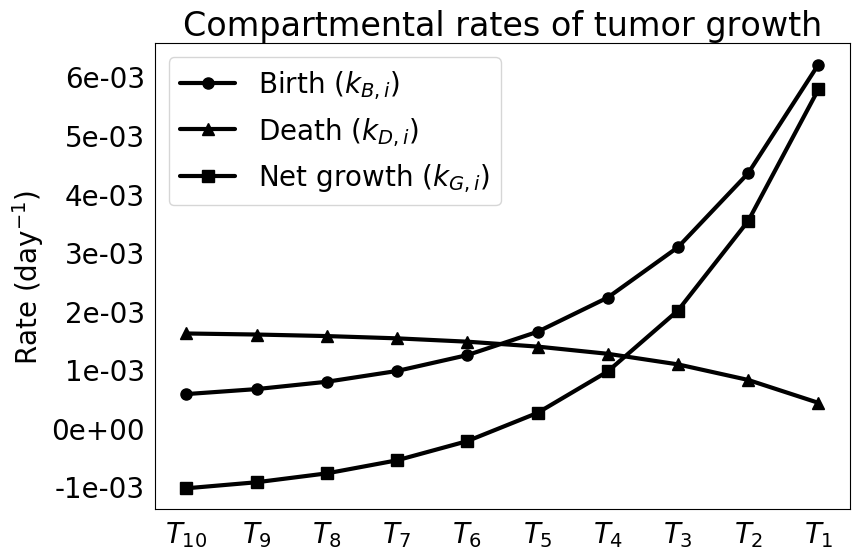

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


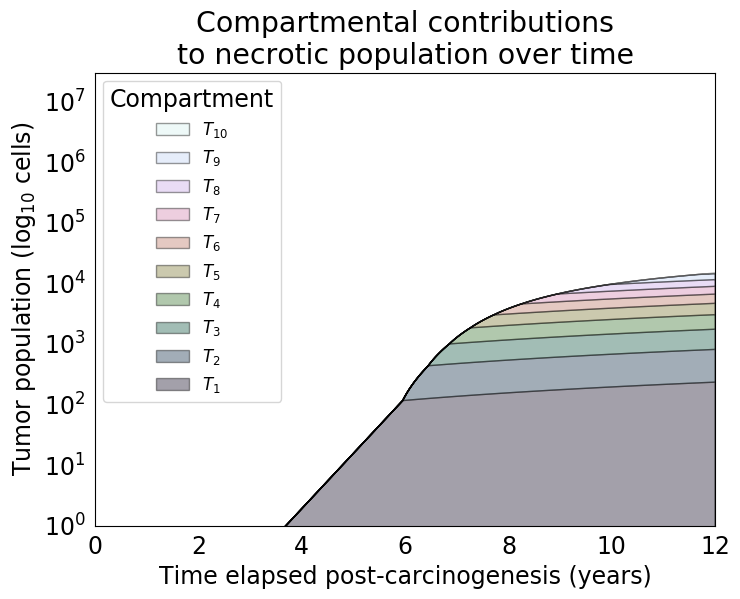

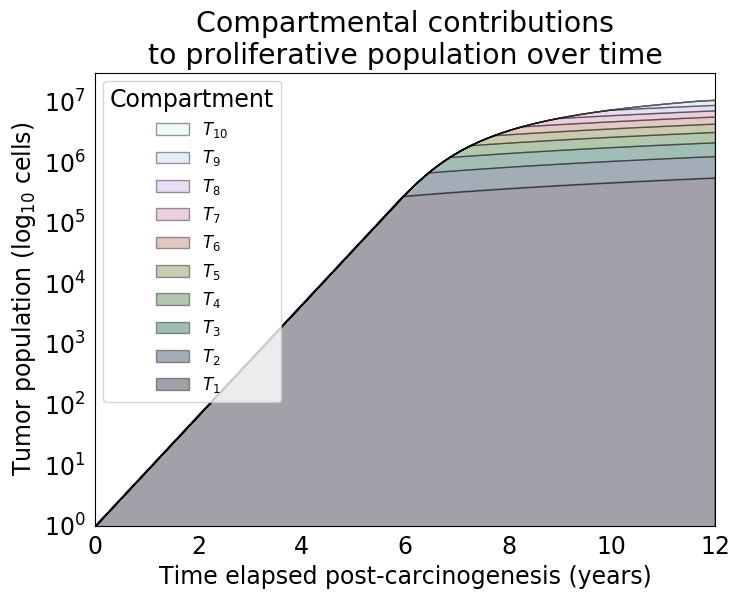

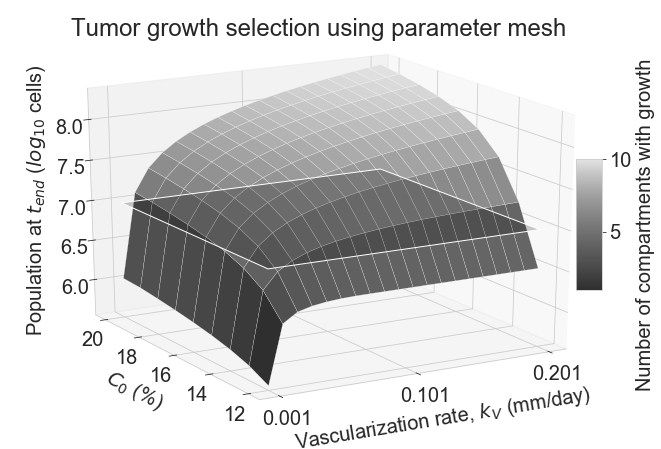

In [10]:
analyze_mesh(mesh_cached)

## 2. Tumor growth sensitivity analyses

In [11]:
# parameters of run (toggle) -- False overrides the cache
sens_cached = True

In [12]:
n_points = 5

# kv - sensitivity search params
O2maxs_2 = (O2a + O2b) / 2
kvs_1 = np.linspace(kva, kvb, n_points)

# O2max/Phi0 - sensitivity search params
O2maxs_1 = np.linspace(O2a, O2b, n_points)
kvs_2 = (kva + kvb) / 2


if sens_cached == False:
    print(
        "\nOverwriting and running full SENS... This may take a minute.")

    grow_objs_kv = []
    for i in range(0, n_points):
        grow_obj = GrowObj(maxIter, kvs_1[i], O2maxs_1, sigma, rates)
        grow_objs_kv.append(ST_grow(grow_obj))

    grow_objs_O2 = []
    for i in range(0, n_points):
        grow_obj = GrowObj(maxIter, kvs_2, O2maxs_2[i], sigma, rates)
        grow_objs_O2.append(ST_grow(grow_obj))

    if grow_objs_kv is not None:
        serialize(grow_objs_kv, 'sens_kv_cached.obj')
    if grow_objs_O2 is not None:
        serialize(grow_objs_O2, 'sens_O2_cached.obj')

elif sens_cached == True:
    print("\nUsing old SENS run & proceeding with SENS analysis!")



Using old SENS run & proceeding with SENS analysis!


In [13]:
print(kvs_1)
print(O2maxs_2)

[0.001   0.05075 0.1005  0.15025 0.2    ]
16.0


In [14]:
print(O2maxs_1)
print(kvs_2)

[12. 14. 16. 18. 20.]
0.1005


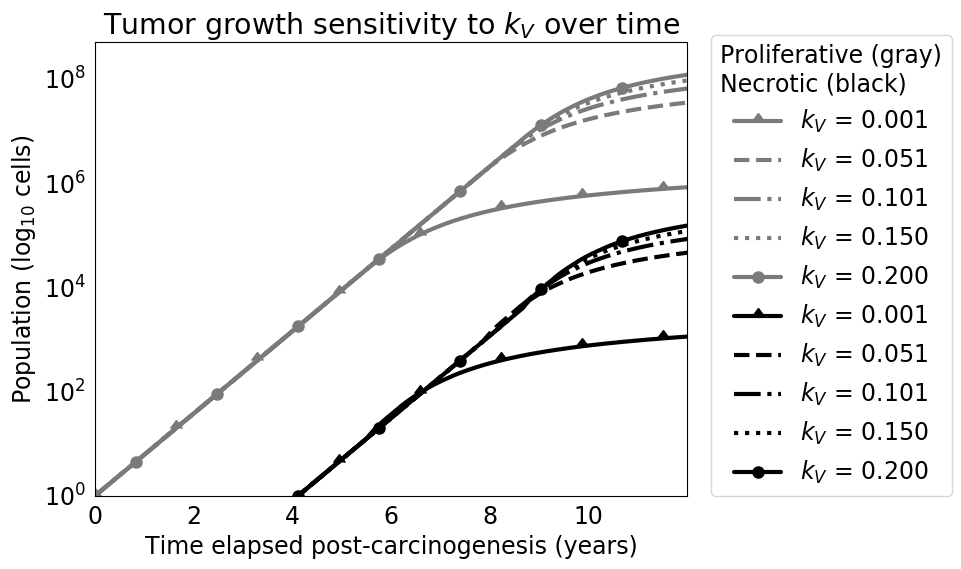

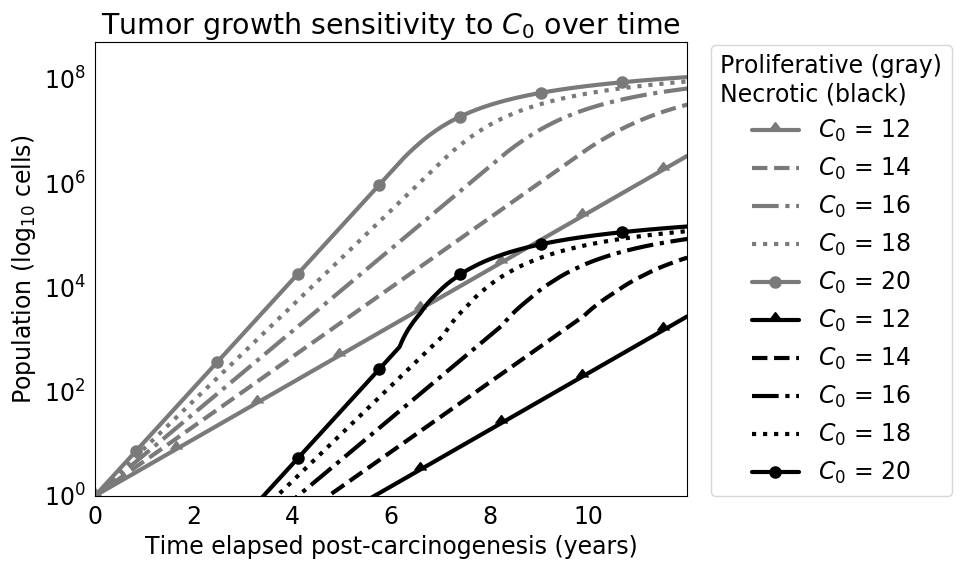

In [15]:
sens_kv_cached = deserialize('sens_kv_cached.obj')
sens_O2_cached = deserialize('sens_O2_cached.obj')

sens_arr = [sens_kv_cached, sens_O2_cached]
kv_arr = [kvs_1, kvs_2]
O2_arr = [O2maxs_1, O2maxs_2]
analyze_growth_sensitivity(sens_arr, kv_arr, O2_arr)

## 3. Shedding simulations

In [16]:
# cached variables
P = deserialize('P.obj')
N = deserialize('N.obj')
n = P.shape[1]

# Constants
th = 6.4  # half-life in days

normalshed_ca125 = 4.56e3 # healthy cell shedding U/day, Hori et al, introducing another parameter
normalshed_ic = 4.56e2 # log order lower

# basal q0
qb_ec = normalshed_ca125
qb_ic = normalshed_ic

# phi and psi
phi_ex = 4.5e-5 * 0.1 # Hori et al's R*f
phi_ic = phi_ex*100 # 2 log orders is what we assume here

Note: Marker2Mice is a marker object that is developed for future use in mouse model studies. With Mass Spec data from tumor and blood samples, we can better estimate inferred parameters. The naming convention is more of a nod to future use than anything else.

In [17]:
mode = "experiment"
Fe = Marker2Mice(1, None, qb_ic, th, None, None, None, phi_ic, normalshed_ic, mode)  
Fne = Marker2Mice(0, None, qb_ic, th, None, None, None, phi_ic, normalshed_ic, mode) 
# assuming phi = psi here for consistency

shed_obj_Fe = ShedObj(Fe, P, N, n, maxIter)
shed_obj_Fne = ShedObj(Fne, P, N, n, maxIter)

shed_obj_Fe = ST_shed(shed_obj_Fe, dt=step)
shed_obj_Fne = ST_shed(shed_obj_Fne, dt=step)

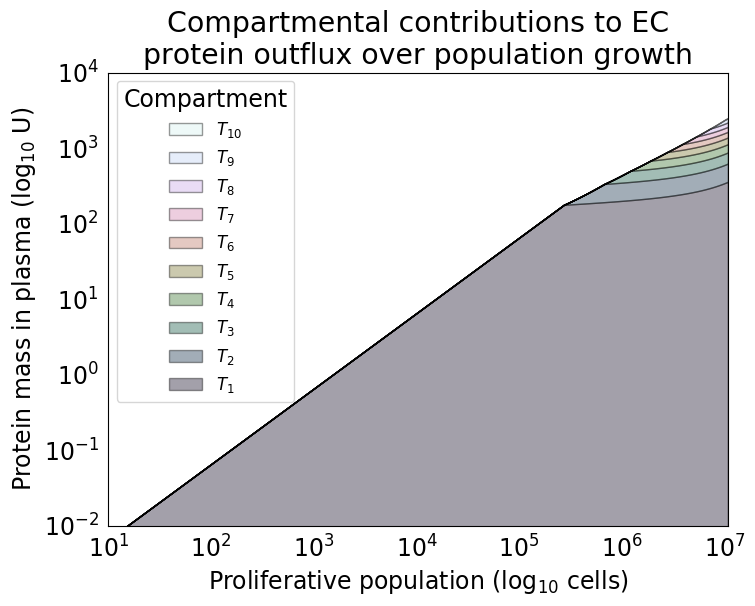

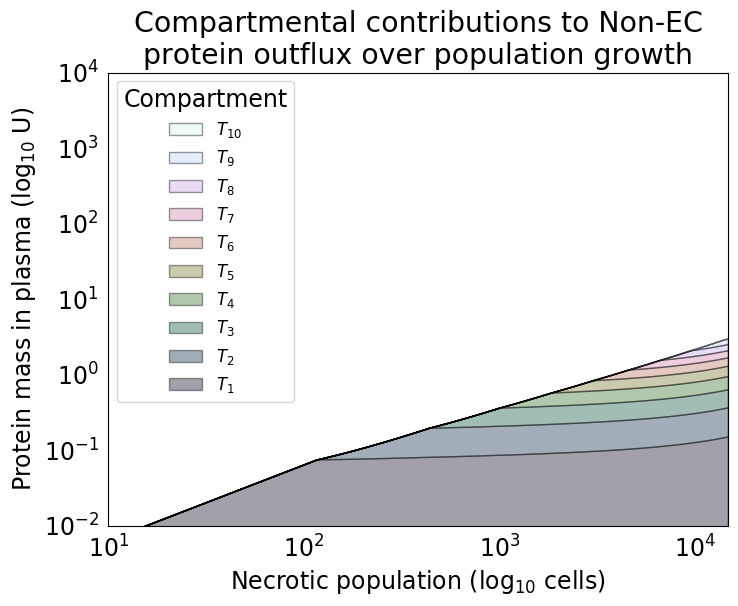

In [18]:
analyze_markerEC(shed_obj_Fe, shed_obj_Fne)

## 4. Grid search - parameter scanning

In [19]:
n_points = 3
mode = "experiment"

Psi_grid = np.logspace(1.5, 6, n_points) * phi_ic
th_grid = np.logspace(-1, 2, n_points) * th # -1, 1.5 | 0, 2.5
uh_grid = np.logspace(-2, 2, n_points) * normalshed_ic


In [20]:
print(Psi_grid)
print(th_grid)
print(uh_grid)

[1.42302495e-02 2.53053596e+00 4.50000000e+02]
[  0.64        20.23857703 640.        ]
[4.56e+00 4.56e+02 4.56e+04]


In [21]:
Fe_ca125 = Marker2Mice(1, None, qb_ec, th, None, None, None, phi_ex, normalshed_ca125, mode)  
Fne_ca125 = Marker2Mice(0, None, qb_ic, th, None, None, None, phi_ic, normalshed_ic, mode) 
# assuming phi = psi here for consistency, but normalshed will differ

markers = [Fe_ca125, Fne_ca125]
combos = [[phi_ex, th, normalshed_ca125],[phi_ic, th, normalshed_ic]]

In [22]:
# grid search
for p in Psi_grid:
    for t in th_grid:
        for uh in uh_grid: 
            combos.append([p, t, uh])
            F = Marker2Mice(0, None, qb_ic, t, None, None, None, p, uh, mode)
            markers.append(F)        
    
sheds = []
for i,F in enumerate(markers):
    so = ShedObj(F, P, N, n, maxIter)
    so = ST_shed(so, dt=step)
    sheds.append(so)

In [23]:
combos

[[4.5e-06, 6.4, 4560.0],
 [0.00045, 6.4, 456.0],
 [0.014230249470757706, 0.6400000000000001, 4.5600000000000005],
 [0.014230249470757706, 0.6400000000000001, 456.0],
 [0.014230249470757706, 0.6400000000000001, 45600.0],
 [0.014230249470757706, 20.238577025077632, 4.5600000000000005],
 [0.014230249470757706, 20.238577025077632, 456.0],
 [0.014230249470757706, 20.238577025077632, 45600.0],
 [0.014230249470757706, 640.0, 4.5600000000000005],
 [0.014230249470757706, 640.0, 456.0],
 [0.014230249470757706, 640.0, 45600.0],
 [2.530535963356571, 0.6400000000000001, 4.5600000000000005],
 [2.530535963356571, 0.6400000000000001, 456.0],
 [2.530535963356571, 0.6400000000000001, 45600.0],
 [2.530535963356571, 20.238577025077632, 4.5600000000000005],
 [2.530535963356571, 20.238577025077632, 456.0],
 [2.530535963356571, 20.238577025077632, 45600.0],
 [2.530535963356571, 640.0, 4.5600000000000005],
 [2.530535963356571, 640.0, 456.0],
 [2.530535963356571, 640.0, 45600.0],
 [450.0, 0.6400000000000001, 4

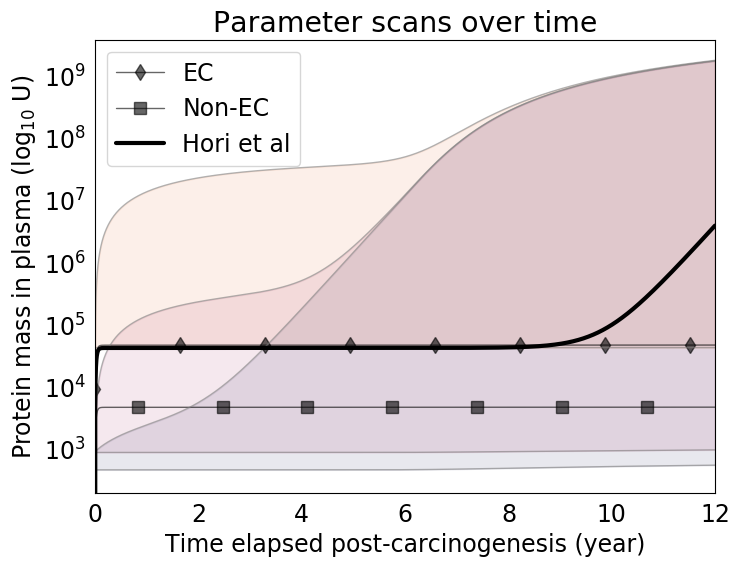

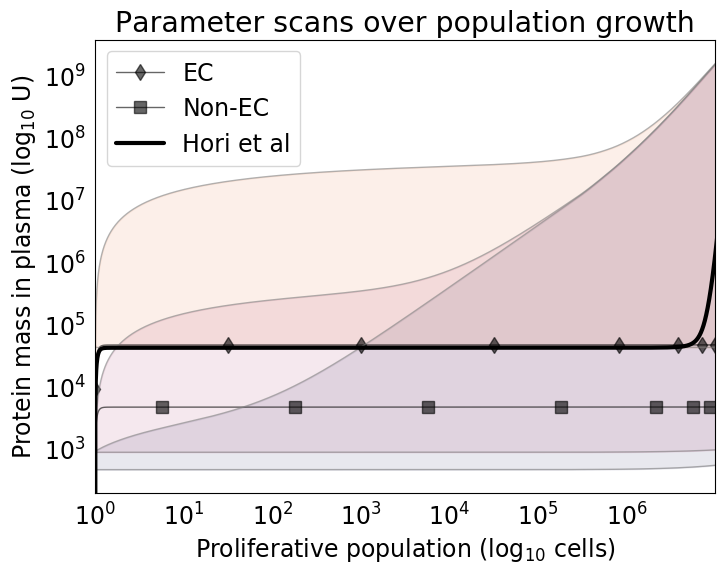

In [24]:
analyze_compete_grid(sheds)

## 5. Shedding sensitivity analysis

In [25]:
mode = "experiment"

grow_objs_kv = deserialize('sens_kv_cached.obj')
grow_objs_O2 = deserialize('sens_O2_cached.obj')
n_points = len(grow_objs_kv)

# kv - hyperparameter
shed_objs_kv = sens_tumor_params(n_points, Fe, Fne, grow_objs_kv, maxIter)

# O2max - hyperparameter
shed_objs_O2 = sens_tumor_params(n_points, Fe, Fne, grow_objs_O2, maxIter)


In [26]:
# Phi, Psi
Psis = np.logspace(0, 3, 5) * phi_ic

Fe_sens_phi = []
Fne_sens_phi = []
for i in range(len(Psis)):
    Fe_sens_phi.append(Marker2Mice(1, None, qb_ic, th, None, None, None, Psis[i], normalshed_ic, mode)) # have to do phi=psi here
    Fne_sens_phi.append(Marker2Mice(0, None, qb_ic, th, None, None, None, Psis[i], normalshed_ic, mode))

shed_objs_phi = sens_marker_params(n_points, Fe_sens_phi, Fne_sens_phi, P, N, n, maxIter)


In [27]:
Psis

array([0.00045   , 0.00253054, 0.01423025, 0.08002257, 0.45      ])

In [28]:
# t_1/2
ths = np.array([th/10, th, th*10, th*50, th*100])

Fe_sens_t = []
Fne_sens_t = []
for i in range(len(ths)):
    Fe_sens_t.append(Marker2Mice(1, None, qb_ic, ths[i], None, None, None, phi_ic, normalshed_ic, mode))
    Fne_sens_t.append(Marker2Mice(0, None, qb_ic, ths[i], None, None, None, phi_ic, normalshed_ic, mode))

shed_objs_t = sens_marker_params(n_points, Fe_sens_t, Fne_sens_t, P, N, n, maxIter)


In [29]:
ths

array([  0.64,   6.4 ,  64.  , 320.  , 640.  ])

In [30]:
# u_H
uhs = np.logspace(0,2,5) * normalshed_ic # same for both ic and ec here

Fe_sens_u = []
Fne_sens_u = []
for i in range(len(uhs)):
    Fe_sens_u.append(Marker2Mice(1, None, qb_ic, th, None, None, None, phi_ic, uhs[i], mode))
    Fne_sens_u.append(Marker2Mice(0, None, qb_ic, th, None, None, None, phi_ic, uhs[i], mode))

shed_objs_u = sens_marker_params(n_points, Fe_sens_u, Fne_sens_u, P, N, n, maxIter)


In [31]:
uhs

array([  456.        ,  1441.99861304,  4560.        , 14419.98613037,
       45600.        ])

In [32]:
print(th, phi_ic, normalshed_ic)

6.4 0.00045 456.0


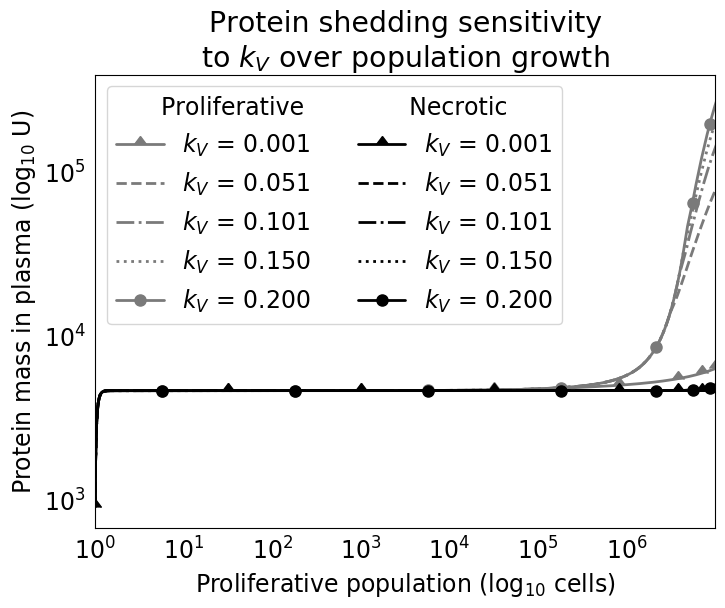

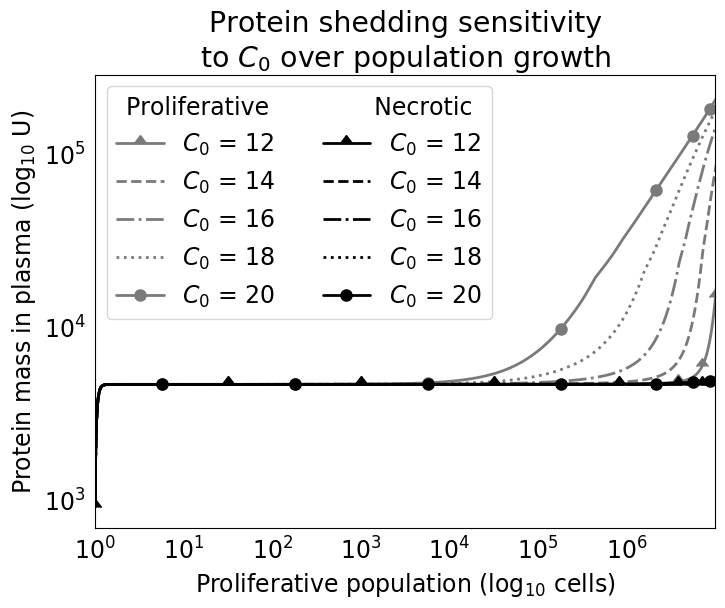

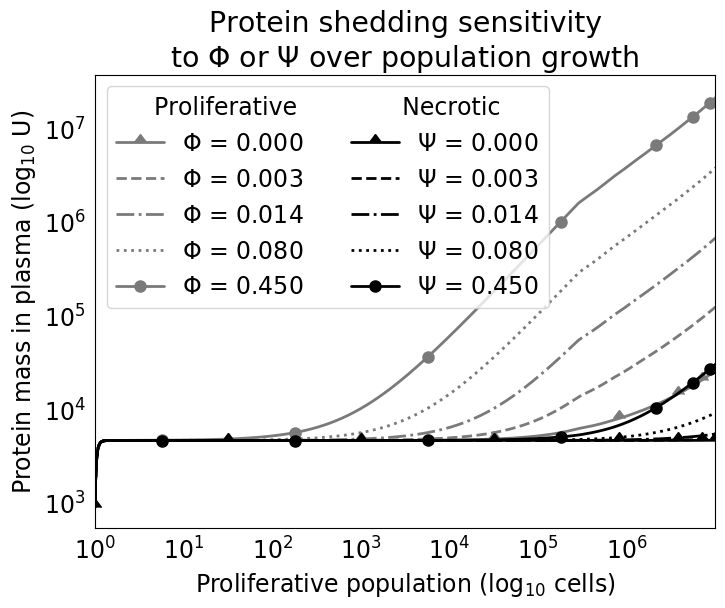

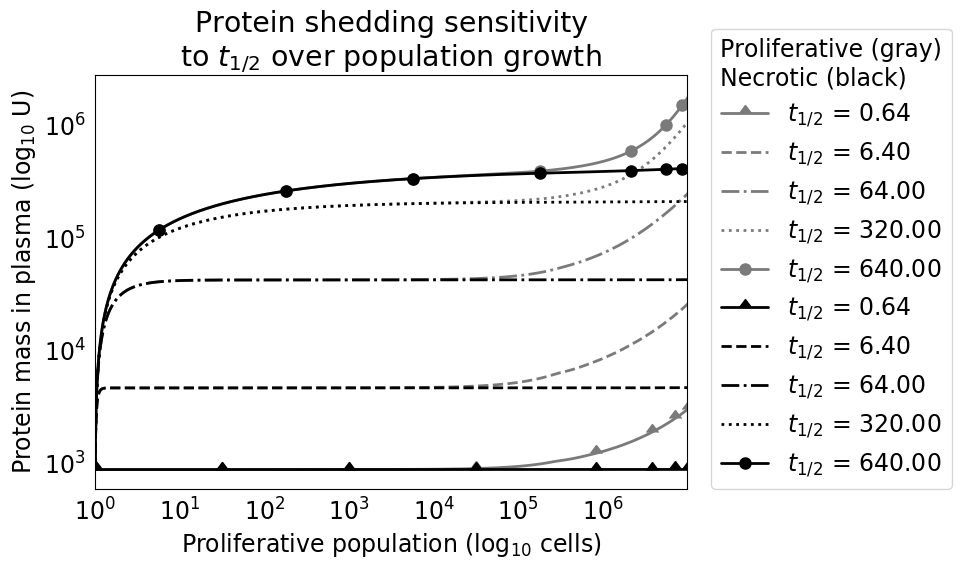

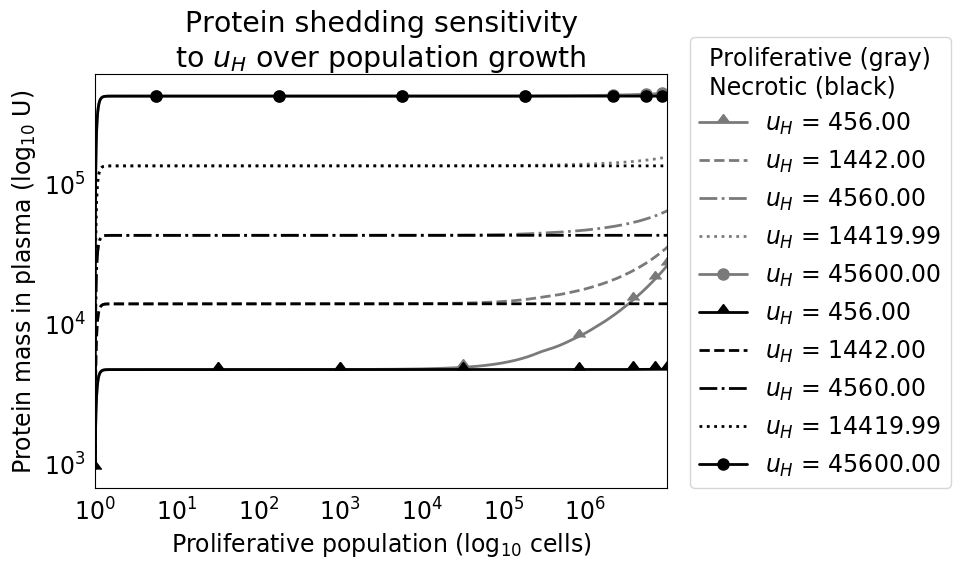

In [33]:
# Run sensitivity 
params = [kvs_1, O2maxs_1, Psis, ths, uhs]
sens_arr = [shed_objs_kv, shed_objs_O2, shed_objs_phi, shed_objs_t, shed_objs_u]
analyze_shed_sensitivity(sens_arr, params, [r"$k_V$", r"$C_0$", r"$\Phi$ or $\Psi$", r"$t_{1/2}$", r"$u_H$"], P)